**Insper**  
**Redes Sociais**

# Projeto:<br/>Best Books Ever

**Jorás Oliveira**  
**Luciano Dias**  
**Tiago Seixas**


In [ ]:
!pip install scikit-learn

In [1]:
import sys
import re
import random
import math
import itertools

import netpixi
from ast import literal_eval
import seaborn as sns
from graph_tool import centrality, spectral, clustering
from matplotlib import pyplot as plt
from netpixi.integration.gt import *
from regression.integration.gt import *
import numpy as np
import pandas as pd
import regression as reg
from sklearn.preprocessing import minmax_scale

np.random.seed(27)

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [3]:
df = pd.read_csv("books_1.Best_Books_Ever.csv", usecols=["title", "series", "rating", "numRatings", "language", "genres"])

df['rating'] = minmax_scale(df['rating'])
df['numRatings'] = minmax_scale(df['numRatings'])
df["language"] = df["language"].map(lambda x: x if x == "English" else "non-English")
df['language'] = df['language'].astype("category")
df['genres'] = df['genres'].apply(literal_eval)

df

,title,series,rating,language,genres,numRatings
0,The Hunger Games,The Hunger Games #1,0.866,English,"[Young Adult, Fiction, Dystopia, Fantasy, Scie...",0.904704
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,0.900,English,"[Fantasy, Young Adult, Fiction, Magic, Childre...",0.355768
2,To Kill a Mockingbird,To Kill a Mockingbird,0.856,English,"[Classics, Fiction, Historical Fiction, School...",0.638589
3,Pride and Prejudice,NaN,0.852,English,"[Classics, Fiction, Romance, Historical Fictio...",0.425375
4,Twilight,The Twilight Saga #1,0.720,English,"[Young Adult, Fantasy, Romance, Vampires, Fict...",0.704340
...,...,...,...,...,...,...
52473,Fractured,Fateful #2,0.800,English,"[Vampires, Paranormal, Young Adult, Romance, F...",0.000124
52474,Anasazi,Sense of Truth #2,0.838,English,"[Mystery, Young Adult]",0.000005
52475,Marked,Soul Guardians #1,0.740,English,"[Fantasy, Young Adult, Paranormal, Angels, Rom...",0.000947
52476,Wayward Son,NaN,0.770,English,"[Fiction, Mystery, Historical Fiction, Adventu...",0.000034


## 1. Construção da rede

In [27]:
SAMPLE_SIZE = 1_500

RECORTE = 5 # depois 6
# 1: Livros que não estão em inglês e que fazem parte de uma série
# 2: Livros que estão em inglês e que fazem parte de uma série
# 3: Livros que fazem parte de uma série
# 4: Livros que não fazem parte de uma série e que não estão em inglês
# 5: Livros que não fazem parte de uma série e estão em inglês
# 6: Livros que não fazem parte de uma série
# 7: Livros que não estão em inglês
# 8: Livros que estão em inglês
# X: Sem recorte

filtered = df

if RECORTE in (1, 2, 3):
    filtered = filtered.loc[df["series"].notna()]
if RECORTE in (4, 5, 6):
    filtered = filtered.loc[df["series"].isna()]

if RECORTE in (1, 4, 7):
    filtered = filtered.loc[df["language"] != "English"]
if RECORTE in (2, 5, 8):
    filtered = filtered.loc[df["language"] == "English"]
    
sample = filtered.sample(SAMPLE_SIZE, replace=False)

g = Graph(directed=False) # não dirigido
g.add_vp('rating')
g.add_vp('clustering')
g.add_ep('weight')

sample

,title,series,rating,language,genres,numRatings
18936,After Birth: Unconventional Writings from the ...,NaN,0.800,English,[Nonfiction],0.000002
17528,Nine Lives,NaN,0.808,English,"[India, Nonfiction, Travel, Religion, History,...",0.000956
11985,The Guide,NaN,0.784,English,"[Fiction, India, Indian Literature, Classics, ...",0.001225
13818,Tidal Mist,NaN,0.848,English,"[Young Adult, New Adult, Fiction, Contemporary...",0.000072
11596,I am Morte,NaN,0.828,English,[],0.000003
...,...,...,...,...,...,...
52349,How to Survive the End of the World as We Know...,NaN,0.756,English,"[Nonfiction, Survival, Reference, How To, Post...",0.000292
6317,The Speed of Life,NaN,0.874,English,"[Fiction, Contemporary, Novels, Drama, Adult, ...",0.000077
52136,The Book of Mary,NaN,0.824,English,[],0.000004
13407,All the President's Men,NaN,0.836,English,"[History, Nonfiction, Politics, Journalism, Am...",0.006646


### 1.1. Operacionalização dos Vertices

In [28]:
for index, row in sample.iterrows():
    vertex = g.add_vertex(index)
    vertex["rating"] = row["rating"]


In [29]:
n = g.num_vertices()

f"{n} vertices na rede."

'2000 vertices na rede.'

#### 1.1.1 Histograma de pesos dos vértices

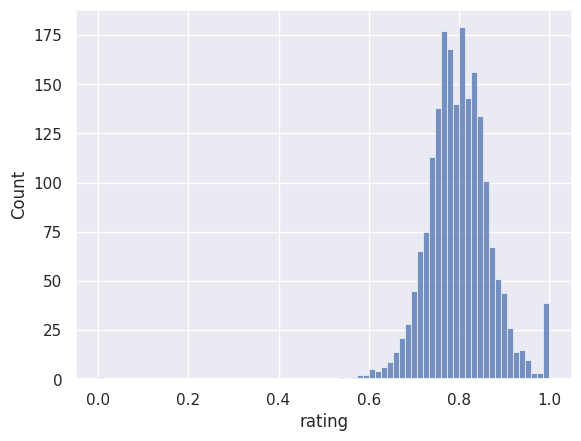

In [30]:
sns.histplot(sample["rating"], binrange=(0, 1));

### 1.2. Operacionalização das Arestas

In [31]:
max_edges = n * (n - 1)

f"{max_edges} arestas possíveis."

'3998000 arestas possíveis.'

In [32]:
def get_weight(g1, r1, n1, g2, r2, n2):
    inter, i1, i2 = np.intersect1d(g1, g2, return_indices=True)
   
    if len(inter) == 0:
        return 0.0
    
    coef_1 = 1 - max(r1, r2) + min(r1, r2)
    coef_2 = 1 - max(n1, n2) + min(n1, n2)
    coef_3 = np.power((
        sum((
                (len(g1) - i1) + (len(g2) - i2)
            ) / (len(g1) + len(g2))
        ) / len(inter)
    ), 1 / len(inter))
   
    return coef_1 * coef_2 * coef_3


In [ ]:
combinations = itertools.combinations(sample.index, 2)
weights = []

for index, (id_1, id_2) in enumerate(combinations):
    row_1 = sample.loc[id_1]
    row_2 = sample.loc[id_2]
    weight = get_weight(row_1["genres"], row_1["rating"], row_1["numRatings"],
                        row_2["genres"], row_2["rating"], row_2["numRatings"])

    if weight > 0.5:
        edge = g.add_edge(id_1, id_2)
        edge["weight"] = weight
 
        weights.append(weight)

    if (index*2) % 1_000 == 0:
        print(f"\r{index*2} {(index*200)//max_edges}%", end="")

print(f"\r{max_edges} 100%")


1566000 39%

In [15]:
m = g.num_edges()

f"{m} arestas na rede. Densidade de {m/max_edges:.5f}"

'951462 arestas na rede. Densidade de 0.23798'

#### 1.2.1 Histograma de pessos das arestas

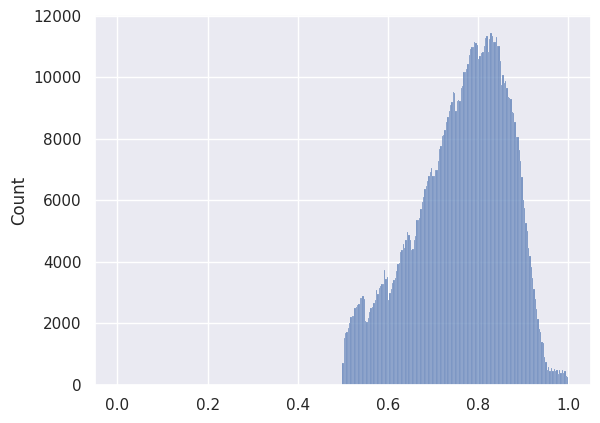

In [17]:
sns.histplot(weights, binrange=(0, 1));

#### 1.2.2 Histograma de degree dos vertices

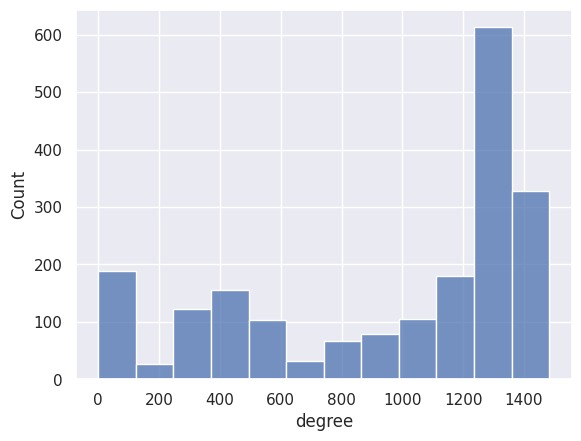

In [18]:
data = gt_data(g)
sample["degree"] = pd.Series([v.total_degree() for v in g.all_vertices()], index=sample.index)

sns.histplot(sample["degree"]);

### 1.3. Limpeza da rede

In [19]:
clear_vertexes = sample.loc[sample["degree"] <= 1].index
sample = sample.drop(clear_vertexes)

for vertex in clear_vertexes:
    g.remove_vertex(vertex)

len(clear_vertexes)

139

## 2.  Regressão dos dados da rede


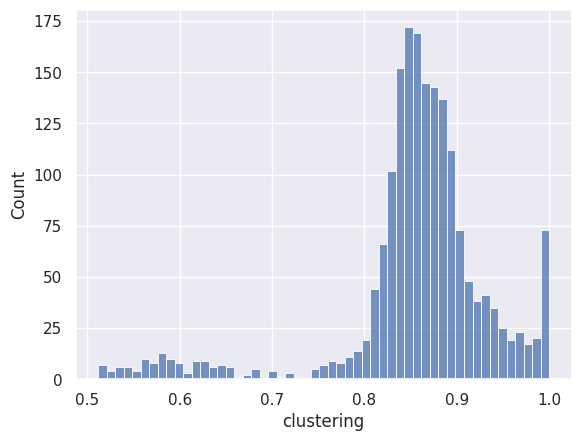

In [20]:
sample["clustering"] = pd.Series(clustering.local_clustering(g), index=sample.index)

for vertex, value in sample["clustering"].items():
    g.vertex_properties["clustering"][vertex] = value

sns.histplot(sample["clustering"]);

In [24]:
result = reg.linear(data=sample, formula='rating ~ clustering + language')

result.micro_summary()

variable,coefficient,std error,p-value
language[T.non-English],0.000000,0.000000,nan
clustering,-0.009427,0.015380,0.539985


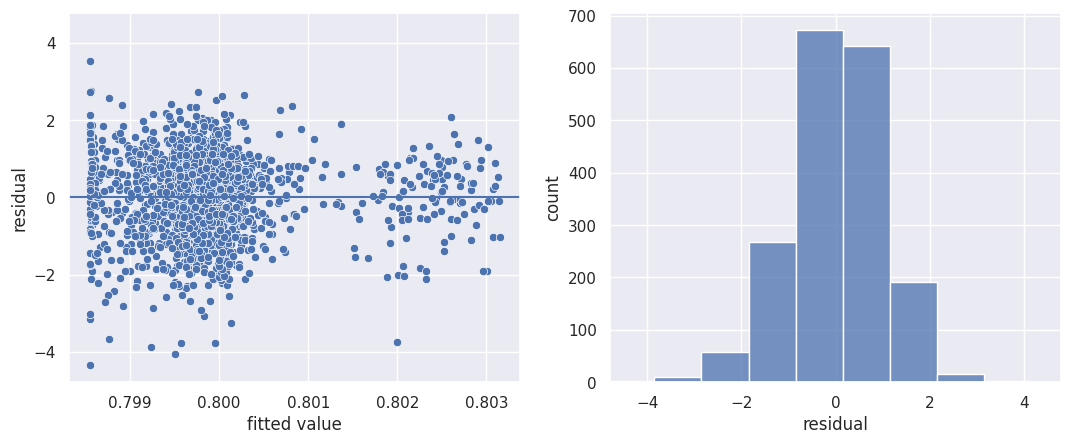

In [22]:
result.plot_residuals()

### 1.3. Limpeza da rede

In [24]:
m = gt_draw.sfdp_layout(g)

gt_move(g, m)
gt_save(g, 'best-books-ever.net.gz')

In [ ]:
r = netpixi.render('best-books-ever.net.gz', infinite=True);

In [26]:
r.edge_scale('weight', 1, 10)
r.vertex_scale('clustering', 5, 20)

In [29]:
sample["clustering"].isna().sum()

0